(techniques:transparent_function_execution)=
# Transparent Symbolic Execution of Function Calls 

In [1]:
import utils
from minipy import *
from semantics import *
from symbolic_interpreter import *

Sometimes, one is not only concerned about the final outcome of a symbolic execution, but additionally intends to explore intermediate states leading to these results. An example application where this is the case is *symbolic debugging* (see {ref}`applications:symbolic_debugging`): If an execution result is not as expected, inspecting intermediate states can help locating and ultimately fixing the issue. Our symbolic interpreter defined in {ref}`foundations:symbolic_interpreter` has a flaw in this regard. Consider again the execution of our linear search program:

In [2]:
program="""
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        else:
            i = i + 1
            continue
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
r = find(x, t)
"""

display_program(program)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        else:
            i = i + 1
            continue
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
r = find(x, t)
```

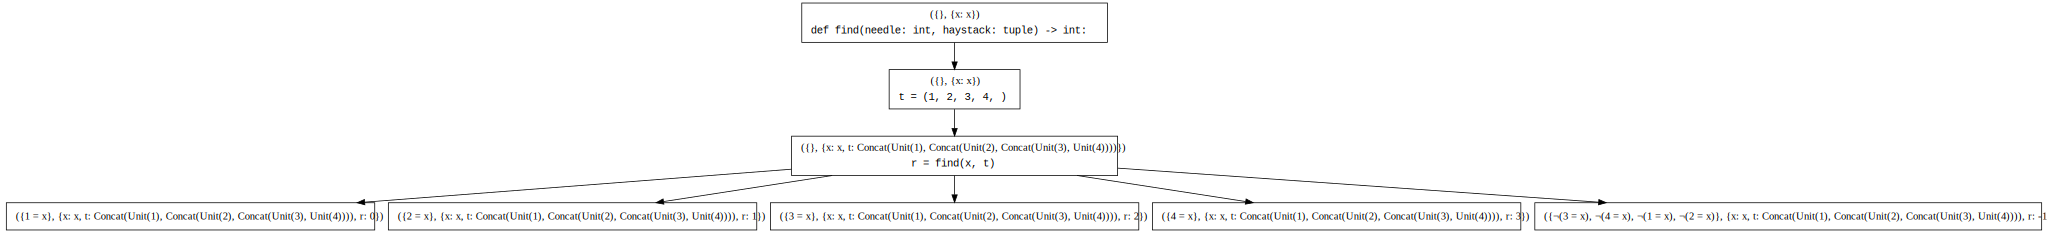

In [3]:
x = Variable("x", INT_TYPE)
env = SymbolicEnvironment(SymbolicStore({x: x.to_z3()}))
predicates = {"len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)}
interpreter = SymbolicInterpreter(predicates=predicates)

tree = interpreter.execute(parse(program), env)
display_set(tree)

Inspecting the execution tree for the function is not much more useful than examining the leaves only, since the tree proceeds from the assignment with the function call to the results of the call *in a single step*. If there was a bug within the `find` method, this SET does not help locating it.

An alternative to our previous design choice of processing a function definition by storing a continuation returning an evaluation result is to *replace* a function call by the function's body. We call this process *inlining*. This approach ensures transparency in the sense that the function body appears in the final SET, but requires some program transformation inside the body. In the case of the minipy language, it suffices to transform `return` statements to assignments. For example, we replace the statement `r = find(x, t)` above with the body of `find`, such that (1) function parameters in the body are instantiated correctly and (2) all `return expr` statements are replaced by `r = expr`. For an object-oriented language, we additionally have to instantiate `self` calls to the containing object and possibly handle visibility rules according to the context of the call.

Instead of encoding the semantics of `return` statements (and `self` expressions and visibility information for more complex languages) by program transformation of the bodies of called functions, we can embed the original bodies into an artificial *wrapper statement providing the required context*, and extend the symbolic interpreter to support such statements. *Method frames* {cite}`ahrendt.beckert.ea-16` as implemented in the KeY [^key] symbolic execution engine for the Java language realize this idea. In the context of minipy, a method frame statement has the following shape:

```python
method-frame(result=var):
    body
```

where `body` is the function body and `var` is a variable name identifying the assignment target of returned expressions inside `body`. We extend the minipy language to support method frames, that is, we add method frames to the grammar, add a new AST node class, and extend the `ASTConverter`. Finally, we re-declare the `parse` function to use the new `ASTConverter` class.

In [4]:
MINIPY_GRAMMAR["<compound_stmt>"].insert(0, "<method_frame>")
MINIPY_GRAMMAR["<method_frame>"] = ["method-frame(result=<NAME>):<block>"]

In [5]:
class MethodFrame(ASTNode):
    def __init__(self, tree: ParseTree, result: 'NameAtom', block: Block):
        super().__init__(tree)
        self.result = result
        self.block = block

In [6]:
class ASTConverter(ASTConverter):
    def __init__(self):
        super().__init__()
        self.stmt_interpretations["<method_frame>"] = self.transform_method_frame_stmt
        
    def transform_compound_stmt(self, stmt: ParseTree) -> ASTNode:
        return self.transform_simple_redirect(
            stmt, ("<method_frame>", "<function_def>", "<try_stmt>", "<if_stmt>", "<while_stmt>"))
        
    def transform_method_frame_stmt(self, stmt: ParseTree) -> MethodFrame:
        m_res = match(("method-frame(result=", "<NAME>", "):", "<block>"), stmt)
        assert m_res is not None

        return MethodFrame(stmt, self.transform_atom(m_res[1]), self.transform_block(m_res[-1]))

In [7]:
def parse(inp: str) -> 'ASTNode':
    inp = strip_comments_and_whitespace(inp)
    tree = PythonPEGParser(MINIPY_GRAMMAR).parse(inp)[0]
    return ASTConverter().transform_top(tree)

Now we should be able to parse a program containing a method frame statement:

In [28]:
mf_stmt = """
x = 17
method-frame(result=x):
    i = 42 + x
    return i
"""

display_program(mf_stmt)

```python
x = 17
method-frame(result=x):
    i = 42 + x
    return i
```

In [29]:
print(repr(parse(mf_stmt))[:571] + "...")

{
  "<type>": "Stmts",
  "code": "x = 17",
  "stmts": [
    {
      "<type>": "Assignment",
      "code": "x = 17",
      "lhs": "x",
      "expression": {
        "<type>": "IntAtom",
        "code": "17",
        "number": 17
      }
    },
    {
      "<type>": "Stmts",
      "code": "method-frame(result=x):",
      "stmts": [
        {
          "<type>": "MethodFrame",
          "code": "method-frame(result=x):",
          "result": {
            "<type>": "NameAtom",
            "code": "x",
            "name": "x"
          },
          "block": {
          ...


## References

```{bibliography}
:filter: docname in docnames
```

[^key]: https://www.key-project.org